# Parler Unmasked: A Data-Driven Exploration of the Lead-up to January 6, 2021

In [1]:
import pandas as pd
import re
import numpy as np

# Loading the cleaned dataset
file_path = "../../data/cleaned/cleaned_dataset.csv"
cleaned_data = pd.read_csv(file_path)

# Displaying the first few rows of the cleaned dataset
cleaned_data.head()

,author_name,author_username,author_profile_photo,post_text,post_image,post_timestamp,post_impressions
0,Andy Ngo,@AndyNgo,https://images.parler.com/777e039d6a5341388549...,philadelphia police charged in relation to an ...,https://api.parler.com/l/GJCyQ,5,132117.0
1,Bill Kays,@rebootbill,https://images.parler.com/706f1c9d8b454b5f8108...,NaN,NaN,4,13.0
2,Flint Bedrock,@flintbedrock,https://images.parler.com/1f45e69f8ed145f9b7b0...,patriots in dc are ready for tomorrow,NaN,5,248971.0
3,Name Hidden,@Private User,../../company-media.parler.com/par-default-pro...,let s follow each other,https://api.parler.com/l/jB7Lz,5,9829.0
4,Name Hidden,@Private User,../../company-media.parler.com/par-default-pro...,NaN,../../api.parler.com/l/6Ac5M.html,5,15689.0


## Finding the Most Frequent Hashtags

In [2]:
# Function to extract hashtags from text
def extract_hashtags(text):
    return re.findall(r'#\w+', str(text))

# Applying the extract_hashtags function to the post_text column and creating a list of all hashtags
all_hashtags = cleaned_data['post_text'].apply(extract_hashtags).explode().dropna()

# Calculating the frequency of each hashtag
hashtag_counts = all_hashtags.value_counts()

# Displaying the top 20 most common hashtags
top_hashtags = hashtag_counts.head(20)
top_hashtags

post_text
#stopthesteal     11609
#maga             11108
#trump            10214
#electionfraud     5558
#americafirst      5135
#election          5008
#georgia           4066
#kag               3721
#saveamerica       3596
#wwg               3402
#trumptrain        3231
#parler            2901
#voterfraud        2880
#fightback         2824
#marchfortrump     2744
#antifa            2663
#dominion          2480
#donaldtrump       2436
#usa               2414
#covid             2292
Name: count, dtype: int64

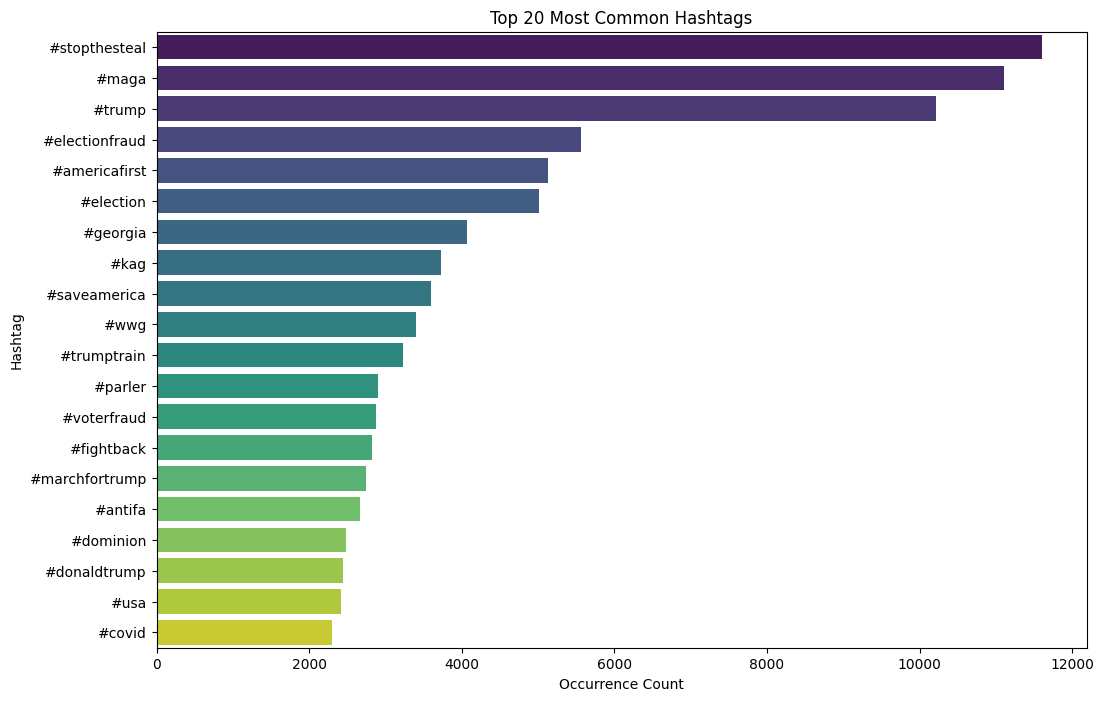

In [3]:
# Importing the Seaborn library
import seaborn as sns
import matplotlib.pyplot as plt

# Selecting the top 20 most common hashtags
top_hashtags = hashtag_counts.head(20)

# Creating a horizontal bar plot using Seaborn
plt.figure(figsize=(12, 8))
sns.barplot(x=top_hashtags.values, y=top_hashtags.index, palette='viridis')
plt.title('Top 20 Most Common Hashtags')
plt.xlabel('Occurrence Count')
plt.ylabel('Hashtag')

plt.savefig("../../models/top_hashtags.png")  

plt.show()

## Vectorization (TF-IDF) and Clustering (MiniBatchKMeans)

In [4]:
from nltk.corpus import stopwords
import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import MiniBatchKMeans

def preprocess_text(text):
    if pd.isnull(text):
        return ''
    nltk.download('punkt', quiet=True)
    nltk.download('stopwords', quiet=True)
    stop_words = set(stopwords.words('english'))
    word_tokens = nltk.word_tokenize(text)
    filtered_text = [w for w in word_tokens if not w in stop_words]
    return " ".join(filtered_text)

# Apply preprocessing to the post_text column
cleaned_data['post_text'] = cleaned_data['post_text'].apply(preprocess_text)

# TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000) # Limiting to 5000 features
tfidf_matrix = tfidf_vectorizer.fit_transform(cleaned_data['post_text'])

# Importing MiniBatchKMeans for clustering
from sklearn.cluster import MiniBatchKMeans

# Defining the MiniBatchKMeans model
minibatch_kmeans = MiniBatchKMeans(n_clusters=10, random_state=42, batch_size=2000)

# Fitting the model to the TF-IDF matrix
minibatch_kmeans.fit(tfidf_matrix)

# Getting the cluster labels for each post
cluster_labels = minibatch_kmeans.labels_

# Adding the cluster labels to the DataFrame
cleaned_data['cluster'] = cluster_labels

# Checking the first few rows to see the cluster labels
cleaned_data.head()

/Users/maggiebreyer/Documents/Education/IronHack/Week_9/Final_project/fin_proj/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1930: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


,author_name,author_username,author_profile_photo,post_text,post_image,post_timestamp,post_impressions,cluster
0,Andy Ngo,@AndyNgo,https://images.parler.com/777e039d6a5341388549...,philadelphia police charged relation # antifa ...,https://api.parler.com/l/GJCyQ,5,132117.0,4
1,Bill Kays,@rebootbill,https://images.parler.com/706f1c9d8b454b5f8108...,,NaN,4,13.0,8
2,Flint Bedrock,@flintbedrock,https://images.parler.com/1f45e69f8ed145f9b7b0...,patriots dc ready tomorrow,NaN,5,248971.0,5
3,Name Hidden,@Private User,../../company-media.parler.com/par-default-pro...,let follow,https://api.parler.com/l/jB7Lz,5,9829.0,1
4,Name Hidden,@Private User,../../company-media.parler.com/par-default-pro...,,../../api.parler.com/l/6Ac5M.html,5,15689.0,8


In [5]:
cleaned_data.to_csv('../../data/cleaned/clustering_model_one.csv', index=False)

In [6]:
def get_top_terms_per_cluster(tfidf_matrix, cluster_labels, vectorizer, num_terms=10):
    # Get feature names from the TF-IDF vectorizer
    feature_names = vectorizer.get_feature_names_out()
    
    # Create a DataFrame to store the TF-IDF matrix
    df_tfidf = pd.DataFrame(tfidf_matrix.toarray())
    
    # Add the cluster labels to the DataFrame
    df_tfidf['cluster'] = cluster_labels

    # Group by cluster and calculate the mean for each term
    cluster_means = df_tfidf.groupby('cluster').mean()
    
    # Get the top terms for each cluster
    top_terms = {}
    for cluster, row in cluster_means.iterrows():
        top_terms[cluster] = [feature_names[i] for i in row.nlargest(num_terms).index]
    
    return top_terms

# Get the top 10 terms for each cluster
top_terms_per_cluster = get_top_terms_per_cluster(tfidf_matrix, minibatch_kmeans.labels_, tfidf_vectorizer, num_terms=10)

# Print the top terms for each cluster
for cluster, terms in top_terms_per_cluster.items():
    print(f"Cluster {cluster}: {', '.join(terms)}")

Cluster 0: votes, explanation, negative, explained, david, taken, georgiathey, perdue, live, still
Cluster 1: let, follow, biden, wtf, us, georgia, live, fraud, see, yes
Cluster 2: people, wow, must, thank, west, wing, hear, right, oval, office
Cluster 3: perdue, vote, votes, georgia, loeffler, warnock, ga, thousand, lead, see
Cluster 4: expecting, holy, cow, america, covid, kamala, harris, king, constitutional, time
Cluster 5: trump, echo, dc, president, follow, patriots, election, watch, georgia, tomorrow
Cluster 6: go, italy, enough, constitution, obama, election, us, politicians, pm, results
Cluster 7: citizen, press, free, plaza, speaking, take, flynn, live, freedom, watch
Cluster 8: biblical, worth, words, starting, maga, thanks, think, bastard, remember, need
Cluster 9: presiding, swear, lt, democratic, session, remove, majority, gov, senator, pennsylvania


In [7]:
import pickle
from scipy.sparse import save_npz

# Save TF-IDF matrix
save_npz('../../models/tfidf_matrix.npz', tfidf_matrix)

# Save TF-IDF vectorizer
with open('../../models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

### Inertia, Silhoutte Score, and Elbow Method

In [8]:
import numpy as np
from sklearn.metrics import silhouette_score

# Sample a random subset of the data (e.g., 10%)
sample_indices = np.random.choice(tfidf_matrix.shape[0], int(tfidf_matrix.shape[0] * 0.1), replace=False)
sample_tfidf_matrix = tfidf_matrix[sample_indices]
sample_labels = minibatch_kmeans.labels_[sample_indices]

# Inertia
inertia = minibatch_kmeans.inertia_

# Silhouette Score on the subset
silhouette_avg = silhouette_score(sample_tfidf_matrix, sample_labels)

print(f"Inertia: {inertia}")
print(f"Silhouette Score (on subset): {silhouette_avg}")

Inertia: 249179.9935481755
Silhouette Score (on subset): 0.03429819725153856


In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Randomly sample 10% of the data
sampled_data_10 = cleaned_data.sample(frac=0.1, random_state=1234)

# TF-IDF vectorization of the sampled preprocessed text
X_sampled_10 = vectorizer.transform(sampled_data_10['post_text'])

# Computing inertia for different values of k (number of clusters) for the sampled data
inertia_sampled_10 = []

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=1234)
    kmeans.fit(X_sampled_10)
    inertia_sampled_10.append(kmeans.inertia_)

# Plotting the Elbow Method for the 10% sampled data
plt.figure(figsize=(10, 6))
plt.plot(K, inertia_sampled_10, 'bx-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.xticks(np.arange(min(K), max(K) + 1, 1.0))
plt.title('Elbow Method (using 10% sampled data) showing the optimal k')
plt.savefig("../../models/elbow_method.png")  
plt.show()

NotFittedError: The TF-IDF vectorizer is not fitted

## Topic Modelling: Latent Dirichlet Allocation (LDA)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Vectorizing the preprocessed text using Count Vectorizer
count_vectorizer = CountVectorizer(max_features=5000)
X_count = count_vectorizer.fit_transform(cleaned_data['post_text'])

# Number of topics to discover
num_topics = 10

# Training the LDA model
lda_model = LatentDirichletAllocation(n_components=num_topics, random_state=1234)
lda_model.fit(X_count)

# Function to display the top words for each topic
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_words = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        topics.append(f"Topic {topic_idx}: {top_words}")
    return topics

# Displaying the top 10 words for each topic
top_words_per_topic = display_topics(lda_model, count_vectorizer.get_feature_names_out(), 10)
top_words_per_topic

### Topic Modelling Visualization

In [ ]:
import pyLDAvis

# Sampling 1% of the data for LDA topic modeling (to manage memory constraints)
sampled_data = cleaned_data.sample(frac=0.01, random_state=1234)

# Create a document-topic matrix
doc_topic_distr = lda_model.transform(X_count)

# Vocabulary and term frequency
vocab = count_vectorizer.get_feature_names_out()
term_frequency = X_count.sum(axis=0).tolist()[0]

# Prepare the data for pyLDAvis visualization
pyLDAvis_data = pyLDAvis.prepare(
    topic_term_dists=lda_model.components_, 
    doc_topic_dists=doc_topic_distr, 
    doc_lengths=sampled_data['post_text'].apply(len).values, 
    vocab=vocab, 
    term_frequency=term_frequency
)

# Display the interactive plot (in a Jupyter Notebook)
pyLDAvis.display(pyLDAvis_data)

# Save the visualization to an HTML file
pyLDAvis.save_html(pyLDAvis_data, '../../models/lda_visualization2.html')

## Time Series Analysis

### Hashtags

In [ ]:
# Converting the post_timestamp into an actual date format
cleaned_data['date'] = pd.to_datetime('2021-01-09') - pd.to_timedelta(cleaned_data['post_timestamp'], unit='D')

# Displaying the first few rows to verify the date conversion
cleaned_data[['post_timestamp', 'date']].head()

In [ ]:
# Extracting hashtags considering both patterns (with and without space after "#")
cleaned_data['hashtags'] = cleaned_data['post_text'].apply(lambda x: re.findall(r'#\S+|#\s+\S+', str(x)))

# Replacing '# ' with '#' in the extracted hashtags
cleaned_data['hashtags'] = cleaned_data['hashtags'].apply(lambda x: [hashtag.replace('# ', '#') for hashtag in x])

# Displaying the first few rows to verify the updated hashtag extraction
cleaned_data[['post_text', 'hashtags']].head()

In [ ]:
from collections import Counter

# Function to find the top 5 hashtags for a given list of hashtags
def top_hashtags(hashtags_list):
    all_hashtags = [hashtag for hashtags in hashtags_list for hashtag in hashtags]
    return Counter(all_hashtags).most_common(5)

# Resampling the data by month and finding the top 5 hashtags for each month
monthly_trending_hashtags = cleaned_data.groupby(pd.Grouper(key='date', freq='M'))['hashtags'].apply(top_hashtags)

# Filtering to include only the months from July 2020 to January 2021
monthly_trending_hashtags = monthly_trending_hashtags['2020-07':'2021-01']

# Displaying the top 5 trending hashtags for each month
monthly_trending_hashtags

In [ ]:
# Printing the top 5 trending hashtags for each month
for month, top_hashtags in monthly_trending_hashtags.items():
    print(f"Month: {month.strftime('%B %Y')}")
    for hashtag, count in top_hashtags:
        print(f"  - {hashtag}: {count} occurrences")
    print()

### LDA

In [ ]:
# Defining the specific range of months for analysis
months_to_analyze = pd.date_range(start='2020-07-01', end='2021-01-31', freq='MS')

# Repeating the LDA analysis for the specific monthly interval from July 2020 to January 2021
monthly_lda_topics_new = {}

# Filtering the data into the specific monthly intervals
for start_month, end_month in zip(months_to_analyze[:-1], months_to_analyze[1:]):
    monthly_posts = cleaned_data[(cleaned_data['date'] >= start_month) & (cleaned_data['date'] < end_month)]['post_text']
    if not monthly_posts.empty:  # Check if there are posts for this month
        monthly_lda_topics_new[end_month.strftime('%B %Y')] = perform_lda(monthly_posts)
    else:
        monthly_lda_topics_new[end_month.strftime('%B %Y')] = ["No posts for this month"]

# Displaying the main topics for the months
monthly_lda_topics_new